To begin copy this notebook to your own drive:

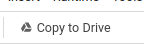


### Submission Instructions:
1. **Restart the kernel** (in the menubar, select Runtime$\rightarrow$Restart runtime)
2. **Download the notebook** (in the menubar, select File$\rightarrow$Download .ipynb)
3. **Upload the downloaded notebook (.ipynb file) to your repository**.


Make sure you fill in any place that says `YOUR CODE HERE`, and that no tests fail.  

Note: To use a GPU, do the following: Runtime$\rightarrow$Change runtime type$\rightarrow$ GPU

In [1]:
import gdown
import nltk
gdown.download('https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn', 'glove.npy', quiet=False)
gdown.download('https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00', 'vocab.json', quiet=False)

nltk.download('punkt')

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn
From (redirected): https://drive.google.com/uc?export=download&id=1PFOG06NEsTL6VieKQjMk1oNzyzcUtiWn&confirm=t&uuid=b22be860-7f63-466d-8b13-0feaaa428214
To: /content/glove.npy
100%|██████████| 480M/480M [00:07<00:00, 65.1MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1-3SxpirQjmX-RCRyRjKdP2L7G_tNgp00
To: /content/vocab.json
100%|██████████| 7.69M/7.69M [00:00<00:00, 70.1MB/s]
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [2]:
!pip install datasets
!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import numpy as np
from datasets import load_dataset


raw_datasets = load_dataset("imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:

from nltk.tokenize import word_tokenize
import json

with open("vocab.json") as f:
  vocab = json.load(f)

def tokenize_function(example):
  sentences = [x.lower() for x in example['text']]
  tokenized_sentences = [word_tokenize(x) for x in sentences]
  tokenized_idx = [[vocab[word] if word in vocab else vocab["unk"] for word in x] for x in tokenized_sentences]
  max_size = max([len(x) for x in tokenized_idx])
  final_tokenized_idx = tokenized_idx

  return {"labels":example['label'],'input_ids':final_tokenized_idx}

In [6]:
small_train_dataset = raw_datasets['train'].shuffle(seed=42).map(tokenize_function,batched=True)
small_eval_dataset = raw_datasets['test'].shuffle(seed=42).map(tokenize_function,batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [7]:
def pad_sequence_to_length(
    sequence,
    desired_length: int,
    default_value = lambda: 0,
    padding_on_right: bool = True,
):
    sequence = list(sequence)
    # Truncates the sequence to the desired length.
    if padding_on_right:
        padded_sequence = sequence[:desired_length]
    else:
        padded_sequence = sequence[-desired_length:]
    # Continues to pad with default_value() until we reach the desired length.
    pad_length = desired_length - len(padded_sequence)
    # This just creates the default value once, so if it's a list, and if it gets mutated
    # later, it could cause subtle bugs. But the risk there is low, and this is much faster.
    values_to_pad = [default_value()] * pad_length
    if padding_on_right:
        padded_sequence = padded_sequence + values_to_pad
    else:
        padded_sequence = values_to_pad + padded_sequence
    return padded_sequence

In [8]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.2 MB/s eta 0:00:00


In [9]:
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [10]:
from dataclasses import dataclass

@dataclass
class DataCollatorWithPadding:

  def __call__(self, features):
    features_dict={}
    if "labels" in features[0]:

      features_dict["labels"] = torch.tensor([x.pop("labels") for x in features]).long()

    input_ids = [x.pop("input_ids") for x in features]
    max_len = max(len(x) for x in input_ids)
    masks = [[1]*len(x) for x in input_ids]

    features_dict["input_ids"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in input_ids]).long()
    features_dict["attention_masks"] = torch.tensor([pad_sequence_to_length(x,max_len) for x in masks]).long()

    return features_dict


In [11]:
from torch import nn
import torch
#Use nn.Sequential and nn.Linear for the network, and nn.CrossEntropyLoss for the loss.
#Make sure that the final layer has output dimension of size 2.
class DAN(nn.Module):
  def __init__(self, p=0.0, num_hidden_layers=1, activation_func=nn.ReLU(), ):
          super().__init__()
          self.num_labels = 2
          self.embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.load("glove.npy")))
          # YOUR CODE HERE
          self.num_hidden_layers = num_hidden_layers
          self.p = p
          self.hidden_size = 256
          self.activation_func = activation_func
          layers = []
          if self.num_hidden_layers == 0:
              layers = [nn.Linear(self.embeddings.embedding_dim, self.num_labels)]
          else:
              for i in range(self.num_hidden_layers):
                  if i == 0:
                      layers.append(nn.Linear(self.embeddings.embedding_dim, self.hidden_size))
                  else:
                      layers.append(nn.Linear(self.hidden_size, self.hidden_size))
                  if activation_func:
                    layers.append(self.activation_func)
              layers.append(nn.Linear(self.hidden_size, self.num_labels))
          self.classifier = nn.Sequential(*layers)
          self.loss = nn.CrossEntropyLoss()
          # END YOUR END



  def forward(self,input_ids,attention_masks,labels=None,**kwargs):
      # YOUR CODE HERE
      embeddings = self.embeddings(input_ids)
      if(self.training):
        mask = torch.bernoulli(torch.ones_like(attention_masks) * (1 - self.p))
        attention_masks = attention_masks * mask
        embeddings = embeddings * mask.unsqueeze(-1)
      avg = torch.sum(embeddings, dim=1) / torch.sum(attention_masks, dim=1).unsqueeze(-1)
      # END YOUR END
      res = self.classifier(avg)
      loss = self.loss(res,labels)
      return {"loss":loss,"logits":res}


In [12]:
#Hint: You may want to look at https://huggingface.co/transformers/main_classes/callback.html
from transformers import Trainer
from transformers import TrainingArguments
from transformers.integrations import TensorBoardCallback
import matplotlib.pyplot as plt


co = DataCollatorWithPadding()
training_args = TrainingArguments("DAN",
                                  # YOUR CODE HERE
                                  num_train_epochs = 20, #must be at least 10.
                                  per_device_train_batch_size=128,
                                  per_device_eval_batch_size=8,
                                  learning_rate= 10e-3,
                                  # END YOUR END

                                  save_total_limit=2,
                                  log_level="error",
                                  evaluation_strategy="epoch")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


## **Section A**

In [ ]:
model = DAN()
trainerA = Trainer(
    model=model,
    data_collator=co,
    args=training_args,
    callbacks = [
                 # YOUR CODE HERE
                  TensorBoardCallback
                 # END YOUR END
    ],
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
    compute_metrics=compute_metrics,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainerA.train()

{'eval_loss': 0.5180814862251282, 'eval_accuracy': 0.7334, 'eval_runtime': 14.1545, 'eval_samples_per_second': 1766.227, 'eval_steps_per_second': 220.778, 'epoch': 1.0}
{'eval_loss': 0.3995755612850189, 'eval_accuracy': 0.81972, 'eval_runtime': 13.9785, 'eval_samples_per_second': 1788.457, 'eval_steps_per_second': 223.557, 'epoch': 2.0}
{'loss': 0.5316, 'grad_norm': 0.26744866371154785, 'learning_rate': 0.08724489795918368, 'epoch': 2.5510204081632653}
{'eval_loss': 0.4029584228992462, 'eval_accuracy': 0.821, 'eval_runtime': 15.5138, 'eval_samples_per_second': 1611.467, 'eval_steps_per_second': 201.433, 'epoch': 3.0}
{'eval_loss': 0.38703516125679016, 'eval_accuracy': 0.82812, 'eval_runtime': 15.9606, 'eval_samples_per_second': 1566.355, 'eval_steps_per_second': 195.794, 'epoch': 4.0}
{'eval_loss': 0.39430922269821167, 'eval_accuracy': 0.82508, 'eval_runtime': 13.7523, 'eval_samples_per_second': 1817.883, 'eval_steps_per_second': 227.235, 'epoch': 5.0}
{'loss': 0.3842, 'grad_norm': 0.3

TrainOutput(global_step=3920, training_loss=0.3919357494432099, metrics={'train_runtime': 655.9191, 'train_samples_per_second': 762.289, 'train_steps_per_second': 5.976, 'train_loss': 0.3919357494432099, 'epoch': 20.0})

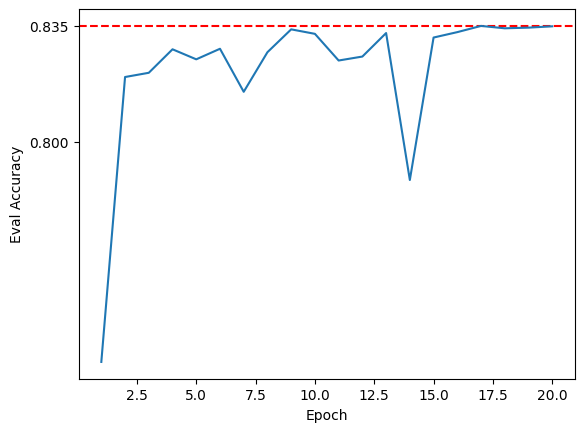

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Eval Accuracy')
eval_accuracy = [d['eval_accuracy'] for d in trainerA.state.log_history if 'eval_accuracy' in d ]
max_accuracy = np.max(np.array(eval_accuracy))
plt.axhline(y=max_accuracy, color='r', linestyle='dashed')
plt.yticks(list(plt.yticks()[0]) + [max_accuracy])
plt.plot(np.arange(1, len(eval_accuracy)+1), eval_accuracy)
plt.show()

## **Section B**


In [ ]:
models = []
trainersB = []
for i, p in enumerate([0.05,0.1,0.2,0.3,0.4]):
  models.append(DAN(p=p))
  trainersB.append(Trainer(
      model=models[i],
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                  TensorBoardCallback
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  ))

In [ ]:
for trainer in trainersB:
  trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.548353,0.737920
2,No log,0.395935,0.825040
3,0.526500,0.407128,0.818000
4,0.526500,0.387400,0.828080
5,0.526500,0.385459,0.827560
6,0.392000,0.393917,0.824360
7,0.392000,0.403277,0.820760
8,0.384600,0.383164,0.830520
9,0.384600,0.388079,0.829240
10,0.384600,0.378674,0.833800


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.414227,0.813160
2,No log,0.435687,0.799480
3,0.558900,0.394841,0.824560
4,0.558900,0.385504,0.829960
5,0.558900,0.384286,0.831480
6,0.393200,0.400581,0.821080
7,0.393200,0.401286,0.820080
8,0.393100,0.383006,0.831240
9,0.393100,0.392386,0.826320
10,0.393100,0.381809,0.831560


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.492419,0.753160
2,No log,0.395139,0.823840
3,0.585600,0.396008,0.823120
4,0.585600,0.385490,0.827840
5,0.585600,0.383344,0.832080
6,0.406800,0.403821,0.817920
7,0.406800,0.403932,0.820520
8,0.402800,0.378905,0.831480
9,0.402800,0.378532,0.833520
10,0.402800,0.387242,0.834440


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.444770,0.789200
2,No log,0.396775,0.824360
3,0.588900,0.428459,0.800240
4,0.588900,0.391202,0.827440
5,0.588900,0.391210,0.826440
6,0.422500,0.431451,0.797760
7,0.422500,0.390931,0.827560
8,0.417900,0.390992,0.827960
9,0.417900,0.381074,0.832680
10,0.417900,0.382654,0.834160


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.430116,0.815480
2,No log,0.406516,0.819400
3,0.614500,0.395428,0.827680
4,0.614500,0.407975,0.821560
5,0.614500,0.393173,0.828040
6,0.445700,0.410977,0.813600
7,0.445700,0.395078,0.826280
8,0.438600,0.391669,0.826880
9,0.438600,0.387401,0.830440
10,0.438600,0.389391,0.831760


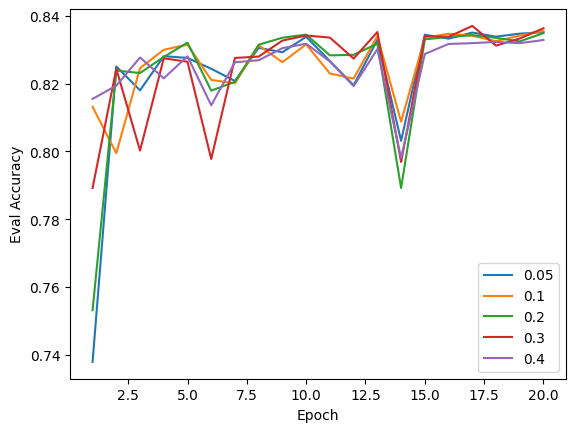

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Eval Accuracy')
for trainer in trainersB:
  eval_accuracy = [d['eval_accuracy'] for d in trainer.state.log_history if 'eval_accuracy' in d ]
  plt.plot(np.arange(1, len(eval_accuracy)+1), eval_accuracy, label= trainer.model.p)
plt.legend()
plt.show()


## **Section C**

	•	Model 0 (No Hidden Layers): Likely has the lowest accuracy because it cannot capture non-linear relationships.
	•	Model 1 and 2 (1–2 Hidden Layers): Expected improvement due to added capacity for learning non-linear patterns.
	•	Model 3 (3 Hidden Layers):
	  •	If the dataset is simple, diminishing returns or overfitting may occur, and the accuracy may plateau or degrade.
	  •	If the dataset is complex, accuracy may improve with regularization and additional data.

In [13]:
models = []
trainersC = []
for i, num_hidden_layers in enumerate([0,1,2,3]):
  models.append(DAN(num_hidden_layers=num_hidden_layers))
  trainersC.append(Trainer(
      model=models[i],
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                  TensorBoardCallback
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  ))

In [14]:
for trainer in trainersC:
  print(trainer.model)
  trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


DAN(
  (embeddings): Embedding(400001, 300)
  (activation_func): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.491248,0.789760
2,No log,0.449315,0.803160
3,0.495100,0.428285,0.813440
4,0.495100,0.417788,0.817080
5,0.495100,0.414169,0.817000
6,0.416300,0.405345,0.821680
7,0.416300,0.405156,0.820880
8,0.398700,0.398054,0.824920
9,0.398700,0.398322,0.824240
10,0.398700,0.393727,0.828720


DAN(
  (embeddings): Embedding(400001, 300)
  (activation_func): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.405037,0.817440
2,No log,0.392854,0.824520
3,0.431700,0.387552,0.825800
4,0.431700,0.404896,0.817120
5,0.431700,0.378797,0.831440
6,0.383600,0.396624,0.821080
7,0.383600,0.383204,0.830920
8,0.373500,0.377673,0.833800
9,0.373500,0.377569,0.834120
10,0.373500,0.371332,0.835960


DAN(
  (embeddings): Embedding(400001, 300)
  (activation_func): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.413746,0.821680
2,No log,0.387285,0.828760
3,0.438300,0.422471,0.802040
4,0.438300,0.393604,0.821680
5,0.438300,0.378831,0.832960
6,0.385000,0.393869,0.825720
7,0.385000,0.383051,0.831160
8,0.374700,0.401416,0.823320
9,0.374700,0.384532,0.831960
10,0.374700,0.373201,0.834760


DAN(
  (embeddings): Embedding(400001, 300)
  (activation_func): ReLU()
  (classifier): Sequential(
    (0): Linear(in_features=300, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=2, bias=True)
  )
  (loss): CrossEntropyLoss()
)


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.397986,0.823160
2,No log,0.407657,0.814200
3,0.442300,0.381020,0.831360
4,0.442300,0.388562,0.826800
5,0.442300,0.375734,0.835400
6,0.387000,0.393169,0.826600
7,0.387000,0.390797,0.831320
8,0.374800,0.391886,0.828880
9,0.374800,0.383738,0.830240
10,0.374800,0.376191,0.833200


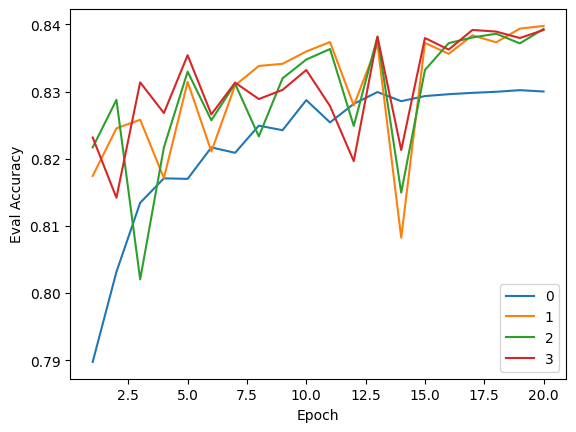

In [4]:
trainersC = [train0, train1, train2, train3]
plt.xlabel('Epoch')
plt.ylabel('Eval Accuracy')
for i, trainer in enumerate(trainersC):
  eval_accuracy = [d['eval_accuracy'] for d in trainer.state.log_history if 'eval_accuracy' in d ]
  plt.plot(np.arange(1, len(eval_accuracy)+1), eval_accuracy, label=i)
plt.legend()
plt.show()

## **Section D**


In [ ]:
models = []
trainersD = []
for i, activation_func in enumerate([nn.ReLU(),nn.GELU(),nn.LeakyReLU()]):
  models.append(DAN(activation_func=activation_func))
  trainersD.append(Trainer(
      model=models[i],
      data_collator=co,
      args=training_args,
      callbacks = [
                  # YOUR CODE HERE
                  TensorBoardCallback
                  # END YOUR END
      ],
      train_dataset=small_train_dataset,
      eval_dataset=small_eval_dataset,
      compute_metrics=compute_metrics,
  ))

In [ ]:
for trainer in trainersD:
  trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.520263,0.743960
2,No log,0.411160,0.814920
3,0.515600,0.402010,0.821080
4,0.515600,0.386158,0.830600
5,0.515600,0.385759,0.830800
6,0.383400,0.402259,0.820640
7,0.383400,0.398585,0.822640
8,0.382700,0.385976,0.830400
9,0.382700,0.385515,0.830640
10,0.382700,0.380144,0.833920


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.695020,0.501080
2,No log,0.602407,0.734680
3,0.942800,0.512019,0.735840
4,0.942800,0.504546,0.780960
5,0.942800,0.434347,0.810800
6,0.493000,0.521142,0.727000
7,0.493000,0.563987,0.695120
8,0.450900,0.431542,0.812600
9,0.450900,0.428653,0.820160
10,0.450900,0.432486,0.802680


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.495155,0.766560
2,No log,0.427397,0.810320
3,0.686000,0.455511,0.791680
4,0.686000,0.417985,0.816280
5,0.686000,0.402647,0.819560
6,0.416600,0.447047,0.804360
7,0.416600,0.391505,0.829000
8,0.410700,0.446459,0.805640
9,0.410700,0.388977,0.830280
10,0.410700,0.390876,0.826480


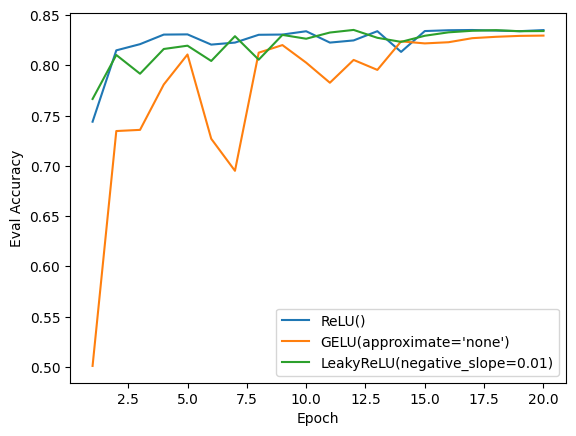

In [ ]:
plt.xlabel('Epoch')
plt.ylabel('Eval Accuracy')
for trainer in trainersD:
  eval_accuracy = [d['eval_accuracy'] for d in trainer.state.log_history if 'eval_accuracy' in d ]
  plt.plot(np.arange(1, len(eval_accuracy)+1), eval_accuracy, label= trainer.model.activation_func)
plt.legend()
plt.show()

In [15]:
predictions = trainersC[2].predict(small_eval_dataset)
predicted_labels = np.argmax(predictions[0], axis=1)
labels = np.array(small_eval_dataset['labels'])
wrong_predictions_idx = (predicted_labels != labels).nonzero()[0]
wrong_idx = np.random.choice(wrong_predictions_idx, size=5, replace=False)
wrong_texts = np.array(small_eval_dataset['text'])[wrong_idx]
for i, (idx, text) in enumerate(zip(wrong_idx, wrong_texts)):
  print(f"$$$$$$$$$$$$$$$$$$$$$$$$ text number {i} $$$$$$$$$$$$$$$$$$$$$$$$")
  print(text)
  print(f"prediction: {predicted_labels[idx]}, Ground Truth: {labels[idx]}")
  print(f"model output: {predictions[0][idx]}")


$$$$$$$$$$$$$$$$$$$$$$$$ text number 0 $$$$$$$$$$$$$$$$$$$$$$$$
I mean let's face it, all you have to do in modelling is pose for photos. The judging is so over the top with it's criticism. The show however is entertaining, especially with Tyra Banks, Nigel Barker, J Alexander and the supermodel herself Twiggy. I've watched season 5, 6, 7 and in the middle of season 8. It looks like American Idol gone sexy but I'm a guy and I only watch it because of the hot girls posing in their bikinis! The show can be quite boring, when it comes to judging, Tyra tends to go on and on and it's really off-putting. Anyway would I recommend it? Yes, Would I recommend it to women wanting to go into the modelling business? No.
prediction: 0, Ground Truth: 1
model output: [ 1.2962973 -1.0719694]
$$$$$$$$$$$$$$$$$$$$$$$$ text number 1 $$$$$$$$$$$$$$$$$$$$$$$$
I was kinda looking forward to Man of the Year, a couple girls at my work said it was a pretty good movie, and my mom said that she liked it, so I wai

### **Text 0 (False Negative)**

  •	The text contains mixed sentiments:

  •	Positive phrases: “entertaining,” “hot girls posing in their bikinis,” and “recommend it.”

  •	Negative phrases: “boring,” “off-putting,” and “wouldn’t recommend it to women wanting to go into the modelling business.”

### **Text 1 (False Positive)**

  •	The text begins with some positive expectations: “looking forward to Man of the Year,” “pretty good movie,” and “liked it.”

  •	However, the review quickly shifts to negative sentiment: “huge disappointment,” “barely made through it,” and “wouldn’t recommend this movie.”

  •	The model may have weighted the initial positive phrases more heavily than the subsequent negative ones, leading to misclassification.

### **Text 2 (False Positive but almost natural)**
  
  •	The text critiques a movie harshly: “unfunny,” “very poor example of filmmaking,” and “nosedived.”

  •	Despite the negative tone, the model output is nearly neutral, with a slight positive tilt.

  •	This could be due to phrases like “short is a perfect example” being misinterpreted as positive.

### **Text 3 (False Positive)**

  •	Positive-sounding phrases like “awesome scenery” and “stunning cinematography” could have led the model to assign a positive sentiment.

  •	Negative phrases, such as “characters are a crashing bore” and “story itself is totally tame,” were likely overshadowed by positive keywords.

### **Text 4 (False Negative but almost natural)**

  •	The text praises the movie as “not half bad,” “good B-horror movie fun,” and “badass,” but also acknowledges typical horror movie flaws like “nothing new” and “cliché.”

  •	The balanced sentiment confused the model, leading it to predict a slightly negative sentiment instead of positive.

